In [1]:
import tensorflow as tf
import tensorflow.contrib.distributions as tfd

import edward as ed
from edward.models import Normal
from edward.models import MultivariateNormalFullCovariance
from edward.models import MultivariateNormalTriL

%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from IPython.display import display

plt.style.use('ggplot')

In [2]:
def load_insteval():  
  url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/'
         'lme4/InstEval.csv')
  with requests.Session() as s:
    download = s.get(url)
    f = download.content.decode().splitlines()

  iterator = csv.reader(f)
  columns = next(iterator)[1:]
  x_train = np.array([row[1:] for row in iterator], dtype=np.int)
  metadata = {'columns': columns}
  return x_train, metadata

data, metadata = load_insteval()
data = pd.DataFrame(data, columns=metadata['columns'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})
data['students'] -= 1  # start index by 0
# Remap categories to start from 0 and end at max(category).
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.tail()

,students,instructors,studage,lectage,service,departments,ratings
453,35,177,8,2,0,13,3
62983,2548,137,2,1,0,9,2
65263,2649,497,2,2,1,3,5
1715,70,839,6,6,0,3,1
14186,550,608,2,3,1,8,2


In [3]:
x_pd_train = train.loc[:, ['studage', 'service', 'lectage']]
y_pd_train = train.loc[:, ['ratings']]

print(x_pd_train.head())
print(x_pd_train.shape)
print(y_pd_train.shape)

x_train = x_pd_train.as_matrix()
y_train = np.squeeze(y_pd_train.as_matrix())


       studage  service  lectage
46488        6        0        5
21322        8        0        5
18612        2        1        1
66869        6        0        2
25306        2        1        1
(58737, 3)
(58737, 1)


<h1>fixed effect model

In [13]:
sess = ed.get_session()

N, D = x_train.shape
fixed_effects = tf.placeholder(tf.float32, [N, D])

beta_fixed_effects = Normal(loc=tf.zeros(D), scale=tf.ones(D))
alpha = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# simple fxied effect model
mu_y = alpha + ed.dot(fixed_effects, beta_fixed_effects)
y = Normal(loc=mu_y, scale=tf.ones(N))

# latent fixed effects
q_beta_fixed_effects = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D])))
)
q_alpha = Normal(
    loc=tf.Variable(tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))
)

latent_vars = {
    beta_fixed_effects: q_beta_fixed_effects,
    alpha: q_alpha
}

sess.run(tf.global_variables_initializer())
inference = ed.KLqp(latent_vars, data={fixed_effects: x_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 113247.906


In [14]:
def compute_mean_absolute_error(y_posterior, X_val_feed_dict, y_val):
    data = {y_posterior: y_val}
    data.update(X_val_feed_dict)
    mae = ed.evaluate('mean_absolute_error', data=data)
    return mae
    
def plot_residuals(y_posterior, X_val_feed_dict, title, y_val):
    y_posterior_preds = y_posterior.eval(feed_dict=X_val_feed_dict)
    plt.figure(figsize=(9, 6))
    plt.hist(y_posterior_preds - y_val, edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(0, color='#A60628', linestyle='--')
    plt.xlabel('`y_posterior_preds - y_val`', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(title, fontsize=16)
    

# fixed effect estimate
display(['alpha', x_pd_train.columns.values])

q_beta_approx = np.mean(q_beta_fixed_effects.sample(500).eval(), axis=0)
q_alpha_approx = np.mean(q_alpha.sample(500).eval(), axis=0)
f_alpha = q_beta_approx
f_beta = q_alpha_approx

display(np.append(q_alpha_approx, q_beta_approx))


['alpha', array(['studage', 'service', 'lectage'], dtype=object)]

array([ 2.9335067e+00,  7.7700622e-02, -1.3016548e-03, -2.9363543e-02],
      dtype=float32)

In [15]:

X_feed_dict = {
  fixed_effects: x_train
}

y_posterior = ed.copy(y, latent_vars)

mae = compute_mean_absolute_error(y_posterior, X_feed_dict, y_train)
print('mae=', mae)

mae= 1.1384969


<h1>random effect model - equal variances

In [18]:
dep_pd_train = train.loc[:, ['departments']]
dep_train = np.squeeze(dep_pd_train.as_matrix())


n_dep = len(set(dep_train))

# random-effect placeholder
dep_data = tf.placeholder(tf.int32, [N])

# random-effect parameter : assume equal covariance structure in dep
sigma_dep = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([])))) * tf.ones(n_dep)
alpha_dep = Normal(loc=tf.zeros(n_dep), scale=sigma_dep)
    
# random effect model
alpha_random_effects = tf.gather(alpha_dep, dep_data)
mu_y = alpha_random_effects 
y = Normal(loc=mu_y, scale=tf.ones(N))

# approximate random-effect distribution
q_alpha_dep = Normal(
    loc=tf.Variable(tf.random_normal([n_dep])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_dep])))
)

latent_vars = {
    alpha_dep: q_alpha_dep
}

sess.run(tf.global_variables_initializer())
inference = ed.KLqp(latent_vars, data={dep_data: dep_train, y: y_train})
inference.run(n_samples=5, n_iter=250)


250/250 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 106241.289


In [119]:
q_alpha_dep_approx = sess.run(q_alpha_dep)
alpha_dep_approx = sess.run(alpha_dep)

# Z estimate of random effect without fixed effect
print('Zmu=', q_alpha_dep_approx)
print('G=', sess.run(sigma_dep)) # G

Zmu= [3.2616158 3.034792  3.2538793 3.2376688 3.3177757 3.1352441 3.1963053
 3.3461442 3.2476082 2.9905765 3.048823  3.3217654 3.140234  3.4214945]
G= [3.2198095 3.2198095 3.2198095 3.2198095 3.2198095 3.2198095 3.2198095
 3.2198095 3.2198095 3.2198095 3.2198095 3.2198095 3.2198095 3.2198095]


In [121]:
X_feed_dict = {
  dep_data: dep_train
}

y_posterior = ed.copy(y, latent_vars)

mae = compute_mean_absolute_error(y_posterior, X_feed_dict, y_train)
print('mae=', mae)

mae= 1.1272258


<h1> random effect model - heterogeneous variances

In [30]:

# n_dep x n_dep diag cov matrix
sigma_dep_cov = tf.diag(tf.sqrt(tf.exp(tf.Variable(tf.random_normal([n_dep])))))
alpha_dep = MultivariateNormalFullCovariance(loc=tf.zeros(n_dep), covariance_matrix=sigma_dep_cov)

alpha_random_effects = tf.gather(alpha_dep, dep_data)
mu_y = alpha_random_effects 
y = Normal(loc=mu_y, scale=tf.ones(N))

# approximate random-effect distribution
q_alpha_dep = Normal(
    loc=tf.Variable(tf.random_normal([n_dep])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_dep])))
)

latent_vars = {
    alpha_dep: q_alpha_dep
}

sess.run(tf.global_variables_initializer())
print('init G=', sess.run(sigma_dep_cov)) # G
inference = ed.KLqp(latent_vars, data={dep_data: dep_train, y: y_train})
inference.run(n_samples=5, n_iter=250)


init G= [[1.029081   0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.8264735  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.39852992 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.5416019  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         1.0534979  0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         1.3505843
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  2.079865   0.         0.         0.         0.       

In [31]:
q_alpha_dep_approx = sess.run(q_alpha_dep)
alpha_dep_approx = sess.run(alpha_dep)

# Z estimate of random effect without fixed effect
print('Zmu=', q_alpha_dep_approx)
print('G=', sess.run(sigma_dep_cov)) # G

Zmu= [3.3674629 2.9415636 3.2403724 3.2213168 3.3243597 3.1481068 3.2820544
 3.0075145 3.1041389 2.9472804 3.0868754 3.330988  3.1402197 3.229673 ]
G= [[10.774364  0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        9.732782  0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.       11.051674  0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.       10.035205  0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.       11.324817  0.        0.
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        9.647827  0.
   0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.

In [32]:
X_feed_dict = {
  dep_data: dep_train
}

y_posterior = ed.copy(y, latent_vars)

mae = compute_mean_absolute_error(y_posterior, X_feed_dict, y_train)
print('mae=', mae)

mae= 1.1289918


<h1>mixed effect - one random effect (dep) equal variance with other covariates fixed effect</h1>
equal variance model

In [26]:
# random-effect parameter : assume equal covariance structure in dep
sigma_dep = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([])))) * tf.ones(n_dep)
alpha_dep = Normal(loc=tf.zeros(n_dep), scale=sigma_dep)

mu_y = alpha + alpha_random_effects + ed.dot(fixed_effects, beta_fixed_effects)
y = Normal(loc=mu_y, scale=tf.ones(N))

latent_vars = {
    beta_fixed_effects: q_beta_fixed_effects,
    alpha: q_alpha,
    alpha_dep: q_alpha_dep
}

sess.run(tf.global_variables_initializer())
print('init G=', sess.run(sigma_dep)) # G
inference = ed.KLqp(latent_vars, data={fixed_effects: x_train, dep_data: dep_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

init G= [0.97989684 0.97989684 0.97989684 0.97989684 0.97989684 0.97989684
 0.97989684 0.97989684 0.97989684 0.97989684 0.97989684 0.97989684
 0.97989684 0.97989684]
250/250 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 121358.398


In [28]:
# fixed effect estimate
q_beta_approx = sess.run(q_beta_fixed_effects)
q_alpha_approx = sess.run(q_alpha)

print(x_pd_train.columns.values)
print(q_beta_approx)
print(q_alpha_approx)

q_alpha_dep_approx = sess.run(q_alpha_dep)

# Z estimate of random effect without fixed effect
print('Zmu=', q_alpha_dep_approx)
print('G=', sess.run(sigma_dep)) # G

['studage' 'service' 'lectage']
[ 0.05875277  0.11151692 -0.08240282]
[2.8785944]
Zmu= [-1.5300514   0.14231429 -0.2920328   0.21554333 -0.43503466 -0.03421251
 -0.34855068  0.36965793  0.66997194  0.81366336  0.19649018  0.25965518
  0.30878806 -0.12333563]
G= [0.6721047 0.6721047 0.6721047 0.6721047 0.6721047 0.6721047 0.6721047
 0.6721047 0.6721047 0.6721047 0.6721047 0.6721047 0.6721047 0.6721047]


In [29]:
X_feed_dict = {
    fixed_effects: x_train,
    dep_data: dep_train
}

y_posterior = ed.copy(y, latent_vars)

mae = compute_mean_absolute_error(y_posterior, X_feed_dict, y_train)
print('mae=', mae)

mae= 1.1350775


<h1> mixed effect with unstructured covariance model</h1>
in this model every pair of dep has its own unique correlation

In [14]:
dep_pd_train = train.loc[:, ['departments']]
dep_train = np.squeeze(dep_pd_train.as_matrix())

n_dep = len(set(dep_train))
tri_n_dep = int(n_dep * (n_dep + 1) / 2)

# random-effect placeholder
dep_data = tf.placeholder(tf.int32, [N])

# for unstructure, covariance has degree of freedom of: n_dep * (n_dep + 1) / 2 
tril_dep = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([tri_n_dep]))))
tril_dep = tfd.fill_triangular(tril_dep)

# random normal using lower triangular cholesky
alpha_dep = MultivariateNormalTriL(loc=tf.zeros(n_dep), scale_tril=tril_dep)
alpha_random_effects = tf.gather(alpha_dep, dep_data)

mu_y = alpha + alpha_random_effects + ed.dot(fixed_effects, beta_fixed_effects)
y = Normal(loc=mu_y, scale=tf.ones(N))

# approximate random-effect distribution
q_alpha_dep = Normal(
    loc=tf.Variable(tf.random_normal([n_dep])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_dep])))
)

latent_vars = {
    beta_fixed_effects: q_beta_fixed_effects,
    alpha: q_alpha,
    alpha_dep: q_alpha_dep
}

sess.run(tf.global_variables_initializer())
print('init G=', sess.run(tf.matmul(tril_dep, tf.transpose(tril_dep))))
inference = ed.KLqp(latent_vars, data={fixed_effects: x_train, dep_data: dep_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

init G= [[ 1.4661205   1.2567146   0.44513345  2.0980053   1.2986672   0.73544854
   0.84401715  0.96918815  1.422813    1.2204816   0.6516401   1.5926483
   0.62585634  1.055317  ]
 [ 1.2567146   1.7324431   1.6622988   3.2350748   2.0865853   1.4187217
   1.8728228   2.8125167   1.8205144   1.5505215   2.1090965   1.9787192
   2.2865708   1.9182717 ]
 [ 0.44513345  1.6622988   5.3640375   5.0454326   4.172286    2.659605
   4.8638096   6.8465652   5.721972    4.0967474   6.9263983   2.5839782
   4.8969765   4.208788  ]
 [ 2.0980053   3.2350748   5.0454326  13.784096    8.878807   10.986081
   7.8173375   9.909452    9.635937    6.7604837   7.817145    5.6738844
   6.8227463   8.332856  ]
 [ 1.2986672   2.0865853   4.172286    8.878807    6.7826943   7.0757318
   6.4946194   8.5500965   7.7550592   6.9959254   7.3082623   4.576431
   7.3657074   7.3113403 ]
 [ 0.73544854  1.4187217   2.659605   10.986081    7.0757318  10.812378
   6.535928    7.6949377   7.7771354   5.9966345   5.8586

In [15]:
# fixed effect estimate
q_beta_approx = sess.run(q_beta_fixed_effects)
q_alpha_approx = sess.run(q_alpha)
q_alpha_dep_approx = sess.run(q_alpha_dep)

print(x_pd_train.columns.values)
print(q_beta_approx)
print(q_alpha_approx)

# Z estimate of random effect without fixed effect
print('Zmu=', q_alpha_dep_approx)
print('G=', sess.run(tf.matmul(tril_dep, tf.transpose(tril_dep))))

['studage' 'service' 'lectage']
[ 0.03710853 -0.09770855 -0.07673685]
[2.3447003]
Zmu= [0.798795   0.80185294 1.0237148  0.96471834 0.9403538  0.88180935
 0.99735165 0.9491084  0.9059565  0.7127774  0.7378387  1.060403
 0.94155735 1.1663647 ]
G= [[ 6.688882   1.6805217  3.196035   3.58497    2.6919034  4.1440687
   1.9928014  3.8834078  2.7782745  3.6089501  2.28403    5.2476892
   1.4535633  3.9973109]
 [ 1.6805217  7.147706   6.310958   3.201768   4.298555   3.1748385
   3.6305506  6.8168106  3.6901498  5.6891193  1.5032123  7.31422
   2.8937173  3.6828547]
 [ 3.196035   6.310958   7.325194   5.507472   5.4685693  5.3713517
   5.671163   8.13764    4.6462884  6.4235187  2.81606    8.426712
   3.7307885  5.410662 ]
 [ 3.58497    3.201768   5.507472  10.535321   6.4953136  8.867864
   9.719269   7.7593846  5.289279   5.579581   8.640089   8.583285
   6.7578154  8.214806 ]
 [ 2.6919034  4.298555   5.4685693  6.4953136  5.4250226  6.2072945
   6.944583   7.500811   4.7216673  5.6884956  

In [11]:
X_feed_dict = {
    fixed_effects: x_train,
    dep_data: dep_train
}

y_posterior = ed.copy(y, latent_vars)

mae = compute_mean_absolute_error(y_posterior, X_feed_dict, y_train)
print('mae=', mae)

mae= 1.1324344


<h1> mixed effects with compound symmetry covariance model

In [64]:
sigma_B = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
sigma_S = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
dep_cov = tf.ones([n_dep, n_dep])
dep_cov = dep_cov * sigma_B + tf.diag(tf.ones([n_dep]) * sigma_S)

alpha_dep = MultivariateNormalFullCovariance(loc=tf.zeros(n_dep), covariance_matrix=dep_cov)
alpha_random_effects = tf.gather(alpha_dep, dep_data)

mu_y = alpha + alpha_random_effects + ed.dot(fixed_effects, beta_fixed_effects)
y = Normal(loc=mu_y, scale=tf.ones(N))

# approximate random-effect distribution
q_alpha_dep = Normal(
    loc=tf.Variable(tf.random_normal([n_dep])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_dep])))
)

latent_vars = {
    beta_fixed_effects: q_beta_fixed_effects,
    alpha: q_alpha,
    alpha_dep: q_alpha_dep
}

sess.run(tf.global_variables_initializer())
print('init G=', sess.run(dep_cov))
inference = ed.KLqp(latent_vars, data={fixed_effects: x_train, dep_data: dep_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

init G= [[1.7084634  0.54182154 0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154 0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154]
 [0.54182154 1.7084634  0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154 0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154]
 [0.54182154 0.54182154 1.7084634  0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154 0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154]
 [0.54182154 0.54182154 0.54182154 1.7084634  0.54182154 0.54182154
  0.54182154 0.54182154 0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154]
 [0.54182154 0.54182154 0.54182154 0.54182154 1.7084634  0.54182154
  0.54182154 0.54182154 0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154]
 [0.54182154 0.54182154 0.54182154 0.54182154 0.54182154 1.7084634
  0.54182154 0.54182154 0.54182154 0.54182154 0.54182154 0.54182154
  0.54182154 0.54182154]
 [0.54182154 0.54182154 0.5

In [24]:
q_beta_approx = sess.run(q_beta_fixed_effects)
q_alpha_approx = sess.run(q_alpha)
q_alpha_dep_approx = sess.run(q_alpha_dep)

print(x_pd_train.columns.values)
print(q_beta_approx)
print(q_alpha_approx)

# Z estimate of random effect without fixed effect
print('Zmu=', q_alpha_dep_approx)
print('G=', sess.run(dep_cov))

['studage' 'service' 'lectage']
[0.13612273 0.20245148 0.10570623]
[1.2693185]
Zmu= [2.0034733 1.8985199 1.9688336 2.056011  2.0506117 2.0208988 2.1265097
 1.9922329 1.7849714 1.5615512 1.7143933 1.9573094 1.7400469 1.9246038]
G= [[3.5868363 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698
  3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698]
 [3.5628698 3.5868363 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698
  3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698]
 [3.5628698 3.5628698 3.5868363 3.5628698 3.5628698 3.5628698 3.5628698
  3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698]
 [3.5628698 3.5628698 3.5628698 3.5868363 3.5628698 3.5628698 3.5628698
  3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698]
 [3.5628698 3.5628698 3.5628698 3.5628698 3.5868363 3.5628698 3.5628698
  3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698 3.5628698]
 [3.5628698 3.5628698 3.5628698 3.5628698 3.5

In [25]:
X_feed_dict = {
    fixed_effects: x_train,
    dep_data: dep_train
}

y_posterior = ed.copy(y, latent_vars)

mae = compute_mean_absolute_error(y_posterior, X_feed_dict, y_train)
print('mae=', mae)

mae= 1.1234922


<h1> random coefficients - random intercept & slope model by department

In [37]:
N, D = x_train.shape
dep_pd_train = train.loc[:, ['departments']]
dep_train = np.squeeze(dep_pd_train.as_matrix())
n_dep = len(set(dep_train))

fixed_effects = tf.placeholder(tf.float32, [N, D])
dep_data = tf.placeholder(tf.int32, [N])

blk_size = D + 1 # alpha + beta for random coeffs
cov_size = n_dep * blk_size

cov = []

tri_n_dep = int(blk_size * (blk_size + 1) / 2)
tril_dep = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([tri_n_dep]))))
tril_dep = tfd.fill_triangular(tril_dep)
x = tf.matmul(tril_dep, tf.transpose(tril_dep))

# construct block diagonal covariance matrix
for bidx in range(cov_size // blk_size):
    row = []    
    
    for ridx in range(blk_size):
        row = []
        row.append(tf.zeros([bidx*blk_size]))
        row.append(x[ridx, :])
        row.append(tf.zeros([cov_size - bidx*blk_size - blk_size]))
        cov.append(tf.expand_dims(tf.concat(row, 0), 0))
    
cov = tf.concat(cov, 0)
    
ab_dep_rnd_coeff = MultivariateNormalFullCovariance(loc=tf.zeros(cov_size), covariance_matrix=cov)
ab_dep_rnd_coeff2 = tf.reshape(ab_dep_rnd_coeff, [-1, blk_size])
alpha_random_effects = tf.gather(ab_dep_rnd_coeff2, dep_data)

# fixed effects
beta_fixed_effects = Normal(loc=tf.zeros(D), scale=tf.ones(D))
alpha = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# equation: fixed effect + random coefficients
mu_y = alpha + alpha_random_effects[:, 0] + ed.dot(fixed_effects, beta_fixed_effects) + tf.reduce_sum(tf.multiply(fixed_effects, alpha_random_effects[:, 1:]), 1)
y = Normal(loc=mu_y, scale=tf.ones(N))

# latent fixed effects and random effects
q_beta_fixed_effects = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D])))
)
q_alpha = Normal(
    loc=tf.Variable(tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))
)

q_ab_dep_rnd_coeff = Normal(
    loc=tf.Variable(tf.random_normal([cov_size])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([cov_size])))
)

latent_vars = {
    beta_fixed_effects: q_beta_fixed_effects,
    alpha: q_alpha,
    ab_dep_rnd_coeff: q_ab_dep_rnd_coeff
}

sess.run(tf.global_variables_initializer())
inference = ed.KLqp(latent_vars, data={fixed_effects: x_train, dep_data: dep_train, y: y_train})
inference.run(n_samples=5, n_iter=250)



250/250 [100%] ██████████████████████████████ Elapsed: 36s | Loss: 129178.477


In [38]:
print("covariance random ab =\n", sess.run([cov[0:blk_size, 0:blk_size]]))
print("random ab per dep =\n")

q_beta_approx = np.mean(q_beta_fixed_effects.sample(500).eval(), axis=0)
q_alpha_approx = np.mean(q_alpha.sample(500).eval(), axis=0)
q_ab_dep_rnd_coeff_approx = np.mean(q_ab_dep_rnd_coeff.sample(500).eval(), axis=0)

display(['alpha', x_pd_train.columns.values])
display(np.append(q_alpha_approx, q_beta_approx))
display(np.reshape(q_ab_dep_rnd_coeff_approx, [-1, blk_size]))

covariance random ab =
 [array([[3.925819  , 0.01578837, 1.516813  , 0.10293268],
       [0.01578837, 0.12780872, 0.16312464, 0.06104178],
       [1.516813  , 0.16312464, 1.0311179 , 0.15380828],
       [0.10293268, 0.06104178, 0.15380828, 0.0527724 ]], dtype=float32)]
random ab per dep =



['alpha', array(['studage', 'service', 'lectage'], dtype=object)]

array([ 1.0009409 ,  0.40325686, -0.3909816 ,  0.08298256], dtype=float32)

array([[ 2.5530136 , -0.41532338,  0.13168837, -0.10625961],
       [ 2.1509106 , -0.39392257,  0.2970216 , -0.10086111],
       [ 2.3258967 , -0.41137716,  0.6837917 , -0.08041536],
       [ 1.7963561 , -0.31170607,  0.43910706, -0.10403178],
       [ 1.7689071 , -0.30221117,  0.35941583, -0.08715337],
       [ 1.7499511 , -0.34665465,  0.34259057, -0.08202011],
       [ 1.394994  , -0.2461289 ,  0.60140896, -0.08933926],
       [ 2.0472693 , -0.3390486 ,  0.31203705, -0.09698718],
       [ 2.003451  , -0.31871024,  0.22324687, -0.14682297],
       [ 0.42372963, -0.15092018,  0.59329045, -0.14838299],
       [ 1.9459518 , -0.28666687,  0.52303123, -0.20401824],
       [ 1.7271454 , -0.30359483,  0.6084539 , -0.11303503],
       [ 2.6997466 , -0.4075665 ,  0.10047672, -0.1562664 ],
       [ 2.000798  , -0.3368434 ,  0.6990196 , -0.13258065]],
      dtype=float32)

array([2.9335067], dtype=float32)

0.07770062

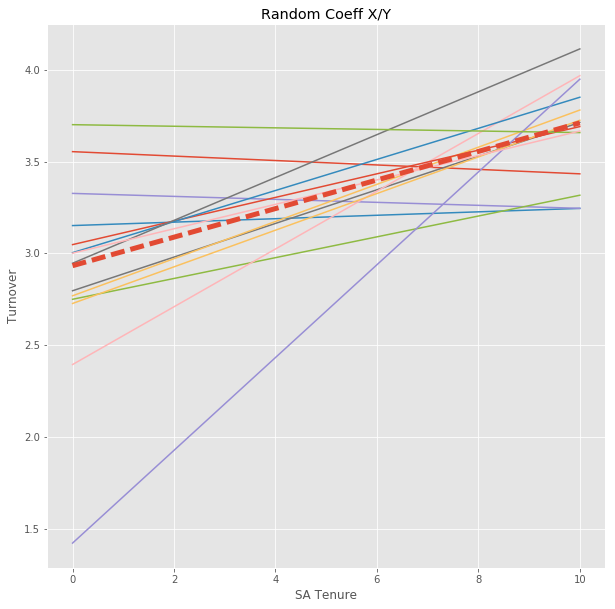

In [44]:
fixed_ab = np.append(q_alpha_approx, q_beta_approx)
random_ab = np.reshape(q_ab_dep_rnd_coeff_approx, [-1, blk_size])

coeff = fixed_ab + random_ab
coeff_studage = coeff[:, :2]

beta = coeff_studage[:, -1] * np.mgrid[0:11, 0:coeff_studage.shape[0]][0]
y_est = beta + coeff_studage[:, 0]

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.set_title('Random Coeff X/Y')
ax.set_xlabel('SA Tenure')
ax.set_ylabel('Turnover')

pp = ax.plot(y_est)

display(falpha)
display(fbeta)

tt = falpha + fbeta * np.mgrid[0:11, 0:1][0]
ax.plot(tt, linewidth=5, linestyle='dashed')

In [11]:
X_feed_dict = {
    fixed_effects: x_train,
    dep_data: dep_train
}

y_posterior = ed.copy(y, latent_vars)

mae = compute_mean_absolute_error(y_posterior, X_feed_dict, y_train)
print('mae=', mae)

mae= 1.1527201
